<a href="https://colab.research.google.com/github/imnbid/SystemIdentification/blob/main/HW1_Implementations/Q3Impliment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

vaiations of teta4:

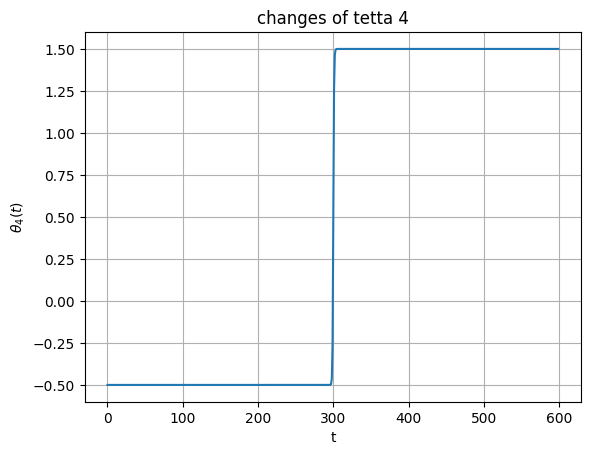

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 600
t = np.arange(N)
g = 1

theta4_true = 0.5 + np.tanh( g*(t - 300) )

plt.plot(t, theta4_true)
plt.xlabel('t')
plt.ylabel(r'$\theta_4(t)$')
plt.title('changes of tetta 4')
plt.grid(True)
plt.show()

Before t=300: negative tanh → θ₄ ≈ 0.5 - 1 → approximately small (lower limit around -0.5). After t=300: positive tanh → θ₄ ≈ 0.5 + 1 → about 1.5. Rapid jump at t=300.

RLS simulation:

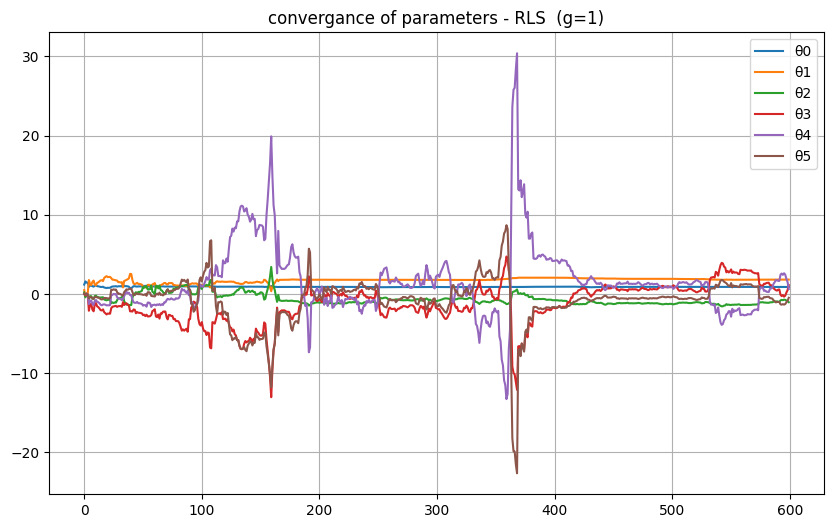

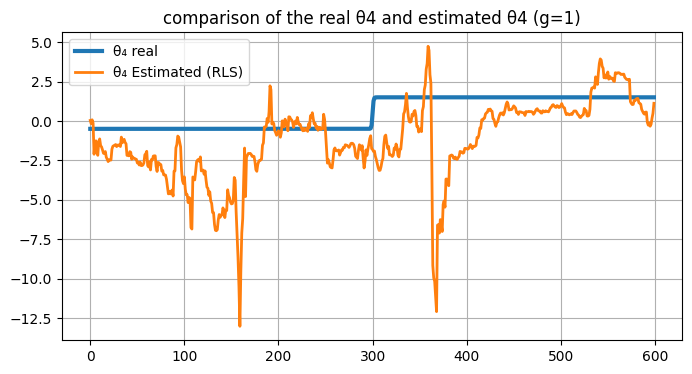

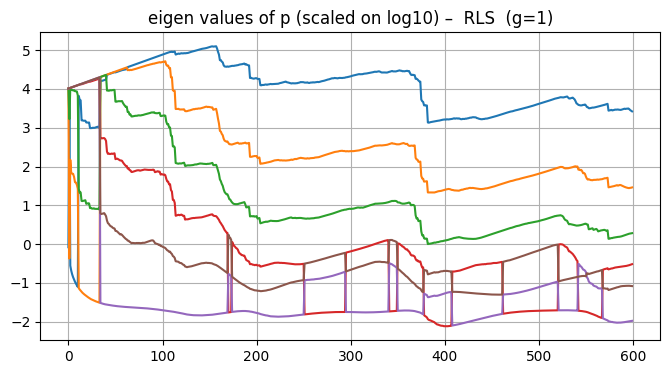

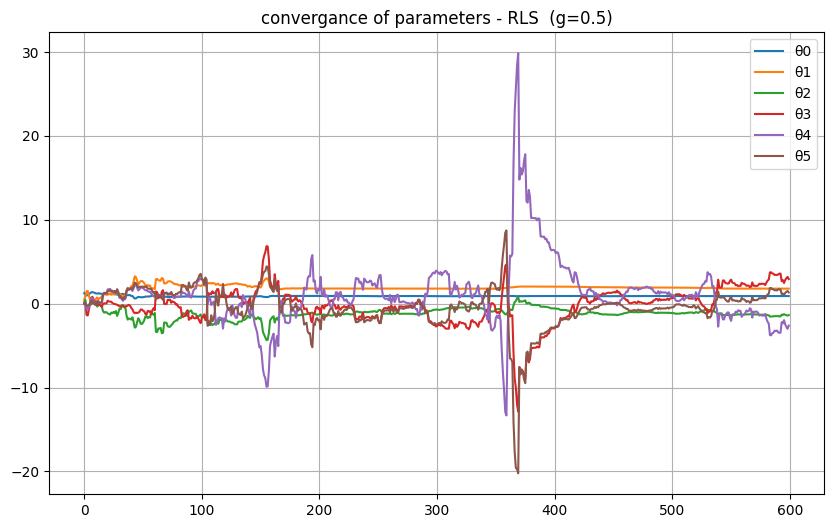

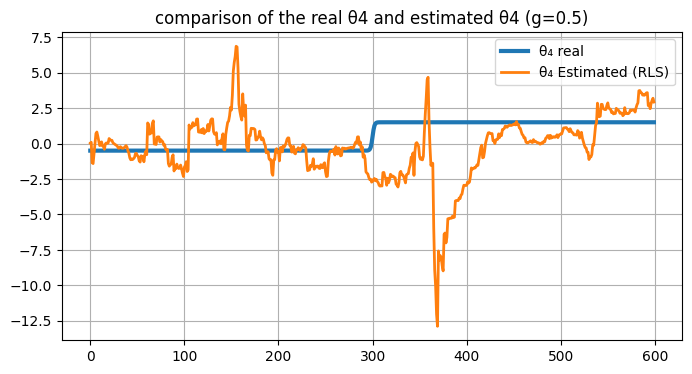

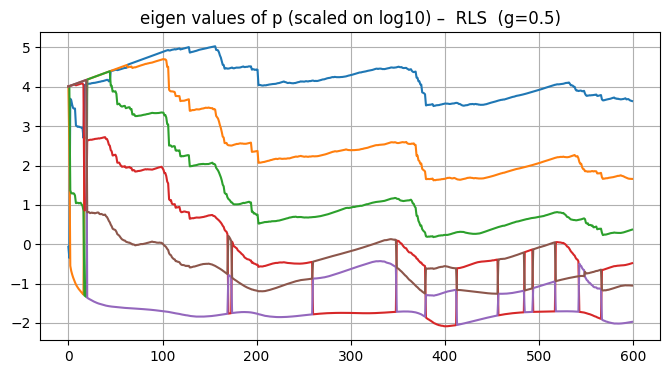

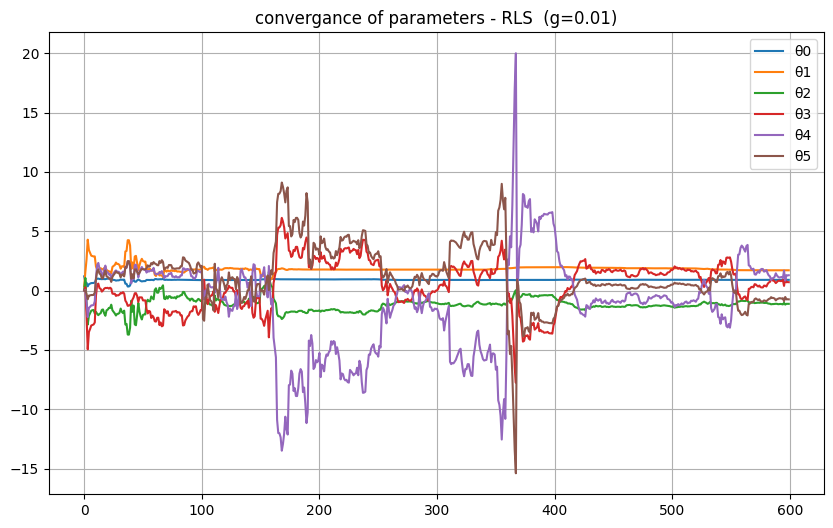

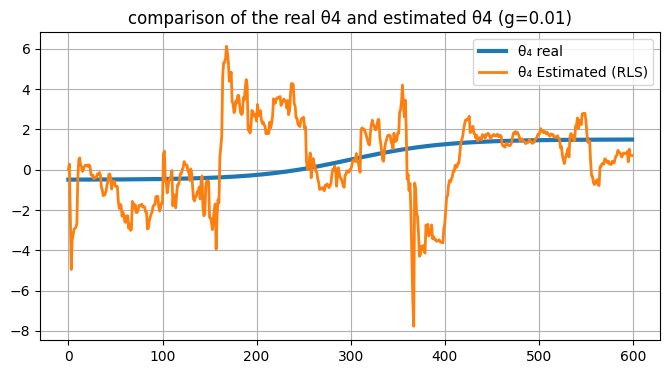

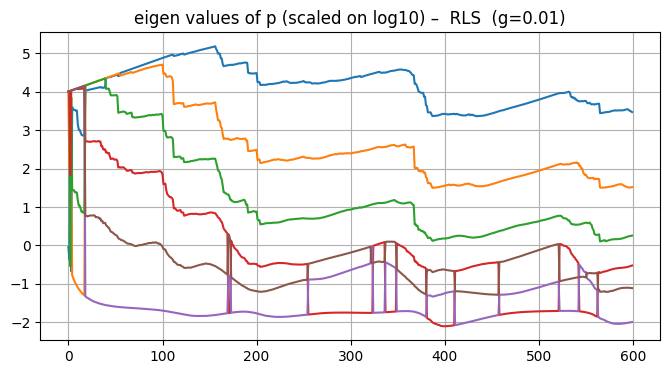


----- g = 1 -----
θ̂ final:
[ 0.89156016  1.82346432 -1.03012083  1.1202555   0.62654761 -0.47654139]
θ₄ real final: 1.5

----- g = 0.5 -----
θ̂ final:
[ 0.90151248  1.78822319 -1.35944303  2.92648101 -2.61612665  1.33677752]
θ₄ real final: 1.5

----- g = 0.01 -----
θ̂ final:
[ 0.9005211   1.70644716 -1.12150665  0.70428775  1.28916936 -0.7432883 ]
θ₄ real final: 1.4949551050784606


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def tansig(x):
    return np.tanh(x)

def theta4(t, g):
    return 0.5 + tansig(g * (t - 300))

# ----------- تولید ورودی -------------
def generate_u(t):
    u = 0.6*np.sin(0.02*t) + 0.4*np.sin(0.05*t + 1.3) + 0.05*np.random.randn(len(t))
    return u

# ---------- مدل خروجی y = θᵀ φ ----------
def generate_y(u, t, g):
    th4 = theta4(t, g)
    y = 0.90 \
        + 1.80*u \
        - 1.10*(u**2) \
        + th4*(u**4) \
        - 0.22*(u**6) \
        + 0.08*(u**8) \
        + 0.05*np.random.randn(len(t))

    return y, th4

# ---------- الگوریتم RLS ----------
def rls(u, y, lam=0.995):
    N = len(u)
    th_hat = np.zeros((N, 6))
    P = np.eye(6) * 1e4
    eigs = []

    for k in range(N):
        phi = np.array([1, u[k], u[k]**2, u[k]**4, u[k]**6, u[k]**8])

        # پیش بینی
        y_hat = th_hat[k-1] @ phi if k > 0 else 0
        e = y[k] - y_hat

        # ماتریس سودگان (Gain)
        K = P @ phi / (lam + phi.T @ P @ phi)

        # به‌روزرسانی پارامتر
        if k == 0:
            th_hat[k] = K * e
        else:
            th_hat[k] = th_hat[k-1] + K * e

        # به‌روزرسانی P
        P = (P - np.outer(K, phi) @ P) / lam

        eigs.append(np.linalg.eigvals(P))

    return th_hat, np.array(eigs)

# ---------- اجرای کامل برای سه مقدار g ----------
g_values = [1, 0.5, 0.01]
t = np.arange(0, 600, 1)

results = {}

for g in g_values:
    u = generate_u(t)
    y, θ4_true = generate_y(u, t, g)

    th_hat, eigs = rls(u, y, lam=0.98)

    results[g] = {
        "theta_hat": th_hat,
        "theta4_true": θ4_true,
        "eigs": eigs
    }

    # ------------------ نمودار پارامترها ------------------
    plt.figure(figsize=(10,6))
    for i in range(6):
        plt.plot(t, th_hat[:, i], label=f"θ{i}")
    plt.title(f"convergance of parameters - RLS  (g={g})")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ------------------ مقایسه θ4 ------------------
    plt.figure(figsize=(8,4))
    plt.plot(t, θ4_true, label="θ₄ real", linewidth=3)
    plt.plot(t, th_hat[:,3], label="θ₄ Estimated (RLS)", linewidth=2)
    plt.title(f"comparison of the real θ4 and estimated θ4 (g={g})")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ------------------ مقادیر ویژه P ------------------
    plt.figure(figsize=(8,4))
    plt.plot(t, np.log10(np.abs(eigs)))
    plt.title(f"eigen values of p (scaled on log10) –  RLS  (g={g})")
    plt.grid(True)
    plt.show()


# چاپ مقادیر نهایی برای مقایسه
for g in g_values:
    print(f"\n----- g = {g} -----")
    print("θ̂ final:")
    print(results[g]["theta_hat"][-1])
    print("θ₄ real final:", results[g]["theta4_true"][-1])


making a better  result can be possible using a windowing mechanism in the RLS algorythm as shown below (self attempt)

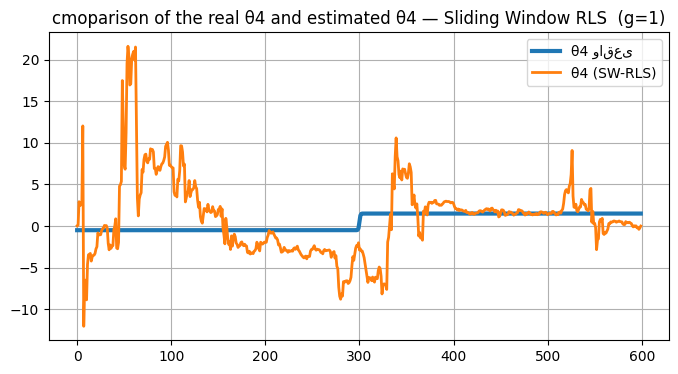

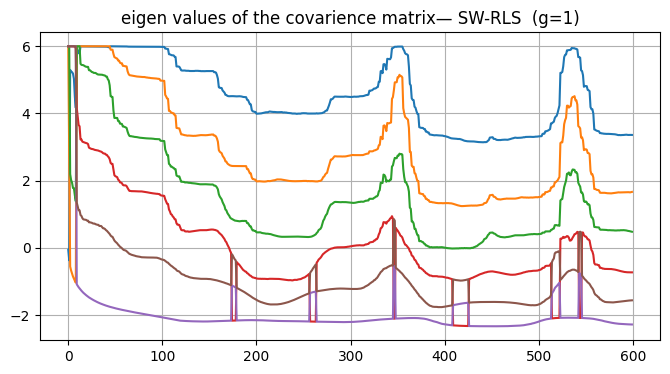

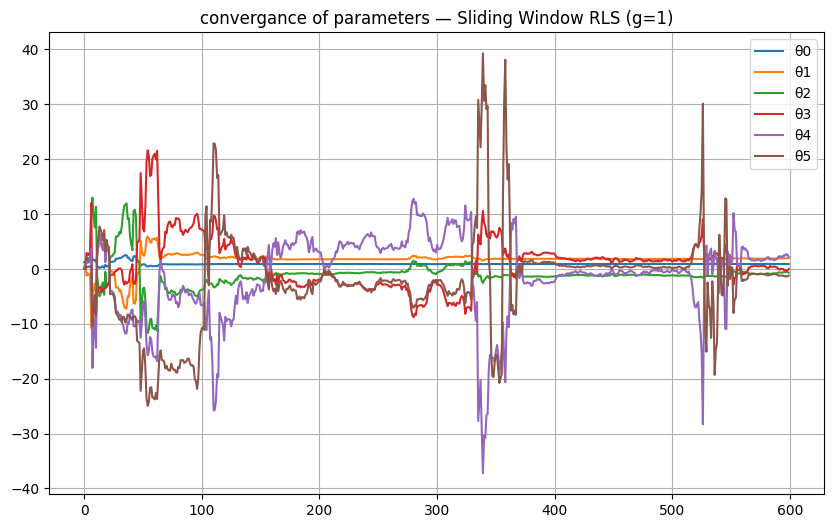

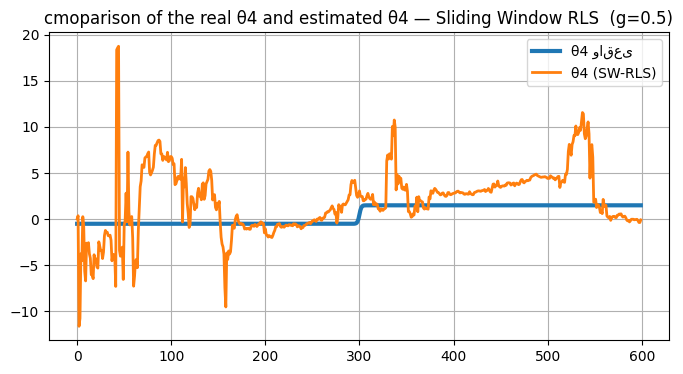

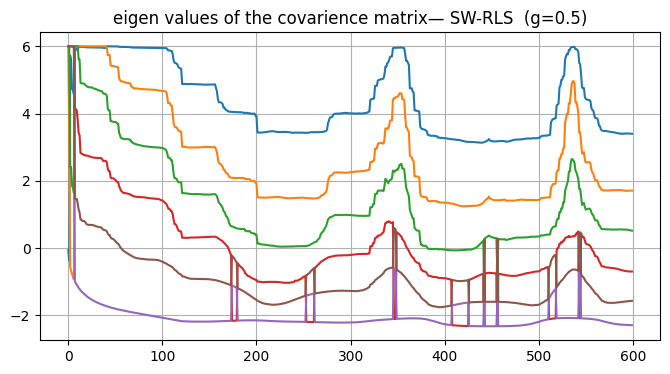

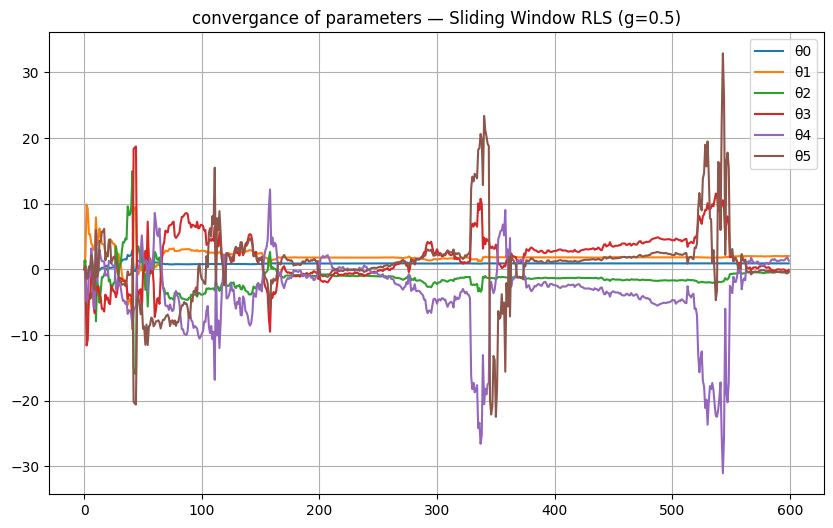

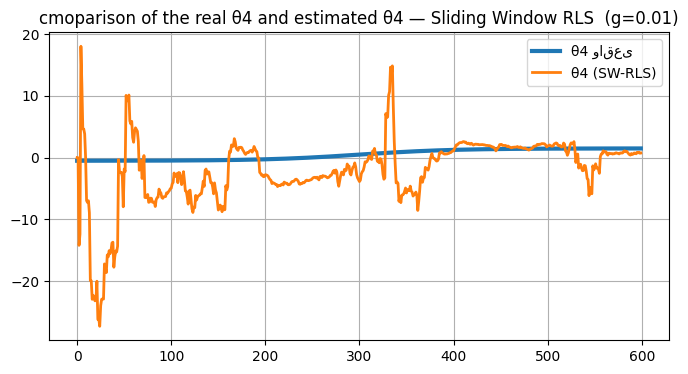

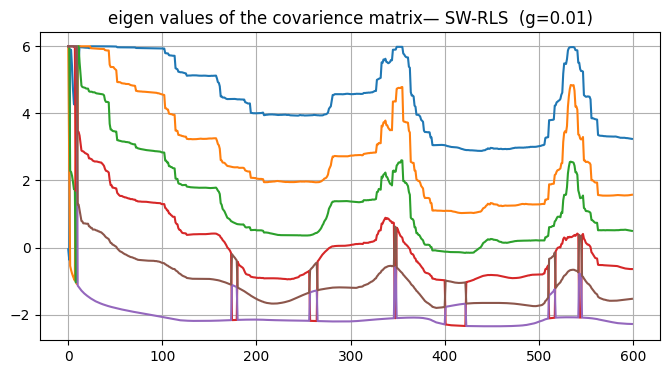

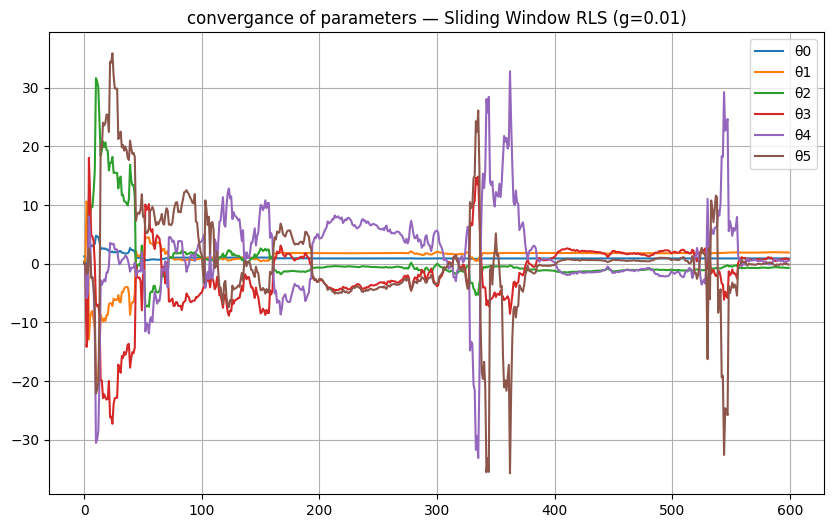

In [3]:
def sliding_window_rls(u, y, W=120):
    """
    u: ورودی سیستم
    y: خروجی سیستم
    W: اندازه پنجره (Window size)
    """
    N = len(u)

    th_hat = np.zeros((N, 6))
    P = np.eye(6) * 1e4

    # ماتریس PHI و Y درون پنجره
    PHI_window = []
    Y_window = []

    eigs = []

    for k in range(N):

        # -----------------------
        # ساخت رگرسور φ(k)
        # -----------------------
        phi = np.array([1, u[k], u[k]**2, u[k]**4, u[k]**6, u[k]**8])

        # افزودن به پنجره
        PHI_window.append(phi)
        Y_window.append(y[k])

        # اگر پنجره بزرگتر شد → حذف داده قدیمی
        if len(PHI_window) > W:
            PHI_window.pop(0)
            Y_window.pop(0)

        # تبدیل به آرایه
        PHI_mat = np.vstack(PHI_window)
        Y_vec = np.array(Y_window)

        # ---------------------------
        # حل LS روی پنجره
        # θ = (ΦᵀΦ + εI)⁻¹ Φᵀ Y
        # ---------------------------
        R = PHI_mat.T @ PHI_mat
        reg = 1e-6 * np.eye(6)     # regularization
        theta_k = np.linalg.inv(R + reg) @ (PHI_mat.T @ Y_vec)

        th_hat[k] = theta_k

        # ذخیره مقادیر ویژه ماتریس کوواریانس معادل
        P = np.linalg.inv(R + reg)
        eigs.append(np.linalg.eigvals(P))

    return th_hat, np.array(eigs)

# ---------------------------
# اجرای روش برای g های مختلف
# ---------------------------
g_values = [1, 0.5, 0.01]
t = np.arange(0, 600)
W = 120   # اندازه پنجره

results_SW = {}

for g in g_values:
    # تولید داده
    u = generate_u(t)
    y, th4_true = generate_y(u, t, g)

    # اجرای Sliding Window RLS
    th_hat, eigs = sliding_window_rls(u, y, W=W)

    results_SW[g] = {
        "theta_hat": th_hat,
        "theta4_true": th4_true,
        "eigs": eigs
    }

    # ------------------ نمودار θ4 واقعی و تخمینی ------------------
    plt.figure(figsize=(8,4))
    plt.plot(t, th4_true, label="θ4 واقعی", linewidth=3)
    plt.plot(t, th_hat[:,3], label="θ4 (SW-RLS)", linewidth=2)
    plt.grid(True)
    plt.title(f"cmoparison of the real θ4 and estimated θ4 — Sliding Window RLS  (g={g})")
    plt.legend()
    plt.show()

    # ------------------ مقادیر ویژه P ------------------
    plt.figure(figsize=(8,4))
    plt.plot(t, np.log10(np.abs(eigs)))
    plt.grid(True)
    plt.title(f"eigen values of the covarience matrix— SW-RLS  (g={g})")
    plt.show()

    # ------------------ تمام پارامترها ------------------
    plt.figure(figsize=(10,6))
    for i in range(6):
        plt.plot(t, th_hat[:,i], label=f"θ{i}")
    plt.grid(True)
    plt.legend()
    plt.title(f"convergance of parameters — Sliding Window RLS (g={g})")
    plt.show()

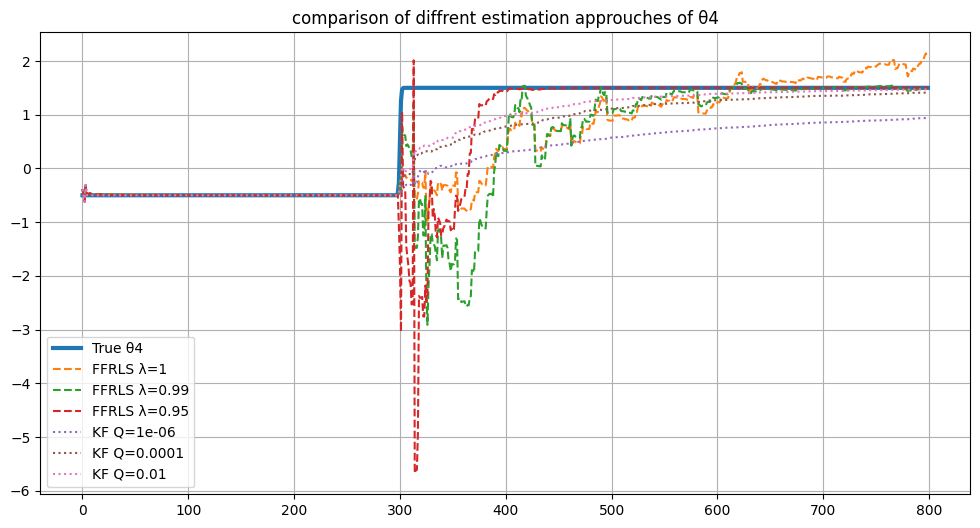

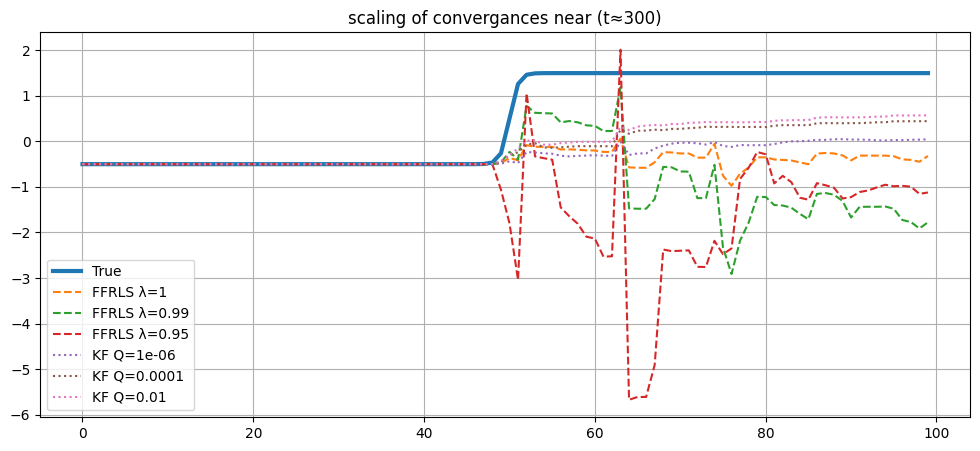

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


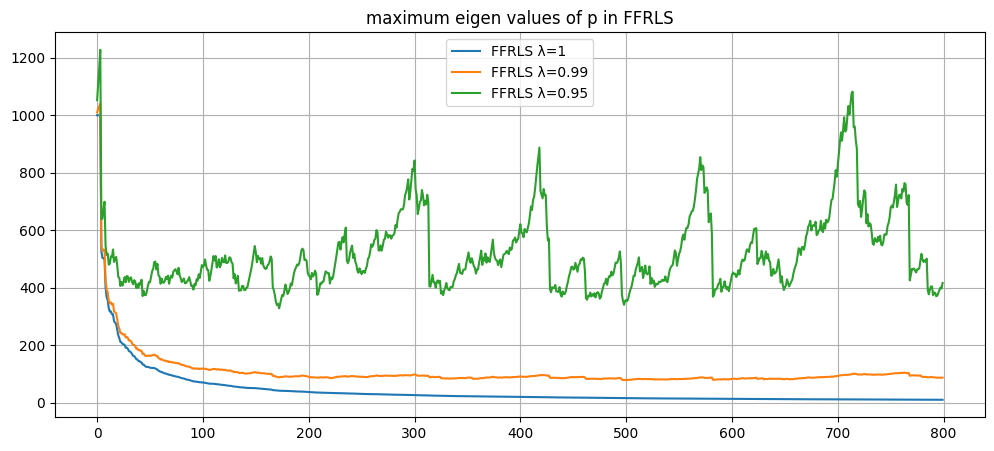

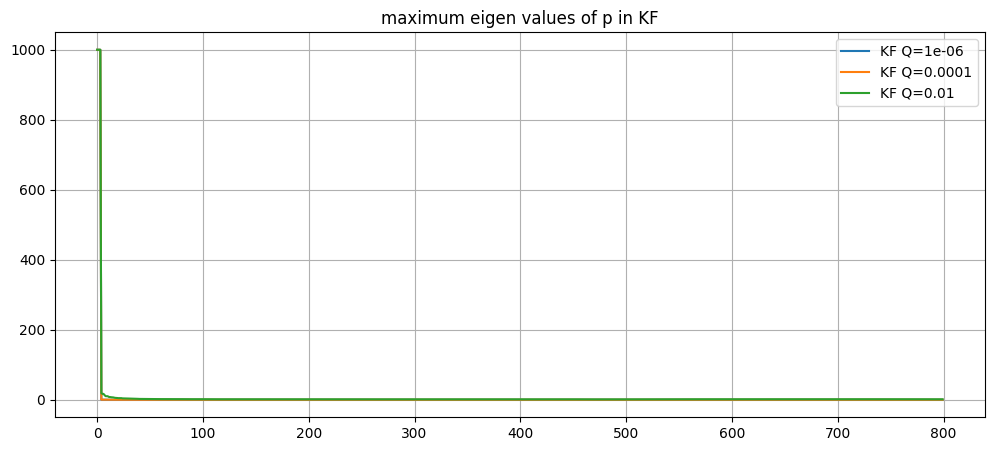

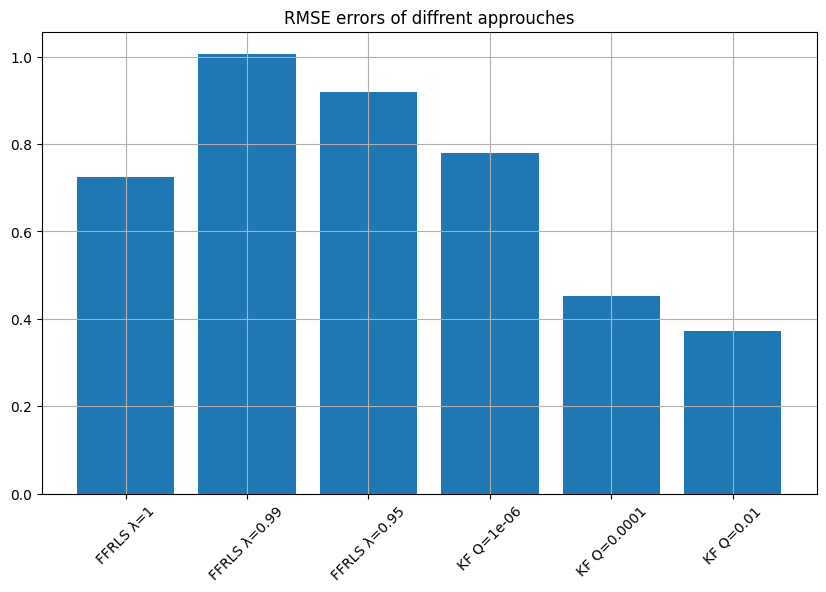

         Method      RMSE
0     FFRLS λ=1  0.725353
1  FFRLS λ=0.99  1.006820
2  FFRLS λ=0.95  0.919234
3    KF Q=1e-06  0.778340
4   KF Q=0.0001  0.453142
5     KF Q=0.01  0.372543


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# 1) تعریف سیستم
# -----------------------------
N = 800
u = np.random.uniform(-1, 1, N)

def theta4_true(t):
    return 0.5 + np.tanh((t-300))

theta_true = np.zeros((N, 5))
for t in range(N):
    theta_true[t] = np.array([
        0.90,
        1.80,
        -1.10,
        theta4_true(t),  # فقط پارامتر 4 تغییر می‌کند
        0.08
    ])

# مدل چهار جمله‌ای انتخاب‌شده
def phi(u):
    return np.array([1, u, u**2, u**4, u**6])

y = np.zeros(N)
for t in range(N):
    y[t] = theta_true[t] @ phi(u[t])

# -----------------------------
# 2) تابع RLS و FFRLS
# -----------------------------
def FFRLS(lambda_f=1.0):
    P = np.eye(5) * 1000
    theta_hat = np.zeros((N, 5))
    P_trace = []

    for t in range(N):
        phi_t = phi(u[t]).reshape(-1,1)
        K = P @ phi_t @ np.linalg.inv(lambda_f + phi_t.T @ P @ phi_t)
        y_hat = theta_hat[t-1] @ phi(u[t]) if t>0 else 0
        e = y[t] - y_hat

        theta_hat[t] = theta_hat[t-1] + (K.flatten()*e if t>0 else (K.flatten()*e))
        P = (1/lambda_f)*(P - K @ phi_t.T @ P)
        P_trace.append(np.max(np.linalg.eigvals(P)))

    return theta_hat, np.array(P_trace)

# -----------------------------
# 3) اجرای FFRLS با مقادیر مختلف λ
# -----------------------------
lambdas = [1, 0.99, 0.95]
results_ffrls = {}
for lam in lambdas:
    theta_est, P_tr = FFRLS(lam)
    results_ffrls[lam] = (theta_est, P_tr)

# -----------------------------
# 4) فیلتر کالمن
# -----------------------------
Q_values = [1e-6, 1e-4, 1e-2]   # مقدارهای مختلف Q
results_kf = {}

for Q in Q_values:
    theta_hat = np.zeros((N, 5))
    P = np.eye(5) * 1000
    R = 1e-4
    P_trace = []

    for t in range(N):
        # Prediction
        theta_hat_pred = theta_hat[t-1] if t>0 else np.zeros(5)
        P = P + Q*np.eye(5)

        # Update
        phi_t = phi(u[t]).reshape(-1,1)
        y_hat = theta_hat_pred @ phi(u[t])
        e = y[t] - y_hat

        S = phi_t.T @ P @ phi_t + R
        K = P @ phi_t @ np.linalg.inv(S)

        theta_hat[t] = theta_hat_pred + (K.flatten()*e)
        P = (np.eye(5) - K @ phi_t.T) @ P

        P_trace.append(np.max(np.linalg.eigvals(P)))

    results_kf[Q] = (theta_hat, np.array(P_trace))

# -----------------------------
# 5) محاسبه RMSE برای روش‌ها
# -----------------------------
rmse_ffrls = {}
for lam in lambdas:
    rmse_ffrls[lam] = np.sqrt(np.mean((results_ffrls[lam][0][:,3] - theta_true[:,3])**2))

rmse_kf = {}
for Q in Q_values:
    rmse_kf[Q] = np.sqrt(np.mean((results_kf[Q][0][:,3] - theta_true[:,3])**2))

# -----------------------------
# 6) رسم نمودارها
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(theta_true[:,3], label='True θ4', linewidth=3)

for lam in lambdas:
    plt.plot(results_ffrls[lam][0][:,3], '--', label=f'FFRLS λ={lam}')

for Q in Q_values:
    plt.plot(results_kf[Q][0][:,3], ':', label=f'KF Q={Q}')

plt.legend()
plt.title('comparison of diffrent estimation approuches of θ4')
plt.grid()
plt.show()


# -----------------------------
# بزرگنمایی اطراف t=300
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(theta_true[250:350,3], label="True", linewidth=3)

for lam in lambdas:
    plt.plot(results_ffrls[lam][0][250:350,3], '--', label=f'FFRLS λ={lam}')

for Q in Q_values:
    plt.plot(results_kf[Q][0][250:350,3], ':', label=f'KF Q={Q}')

plt.legend()
plt.title("scaling of convergances near (t≈300)")
plt.grid()
plt.show()


# -----------------------------
# مقادیر ویژه ماتریس P
# -----------------------------
plt.figure(figsize=(12,5))
for lam in lambdas:
    plt.plot(results_ffrls[lam][1], label=f'FFRLS λ={lam}')
plt.title("maximum eigen values of p in FFRLS")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
for Q in Q_values:
    plt.plot(results_kf[Q][1], label=f'KF Q={Q}')
plt.title("maximum eigen values of p in KF")
plt.legend()
plt.grid()
plt.show()


# -----------------------------
# نمودار میله‌ای RMSE
# -----------------------------
labels = [f"FFRLS λ={l}" for l in lambdas] + [f"KF Q={Q}" for Q in Q_values]
values = list(rmse_ffrls.values()) + list(rmse_kf.values())

plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title('RMSE errors of diffrent approuches')
plt.grid()
plt.show()


# -----------------------------
# جدول نهایی مقایسه
# -----------------------------
methods = labels
rmse_values = values

df = pd.DataFrame({
    "Method": methods,
    "RMSE": rmse_values
})

print(df)
